In [1]:
from LitModel import LitModel
from retriever import TrainRetriever, get_valid_transforms
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import albumentations as A

import numpy as np
import torch
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
device = 'cpu'
backbone = 'efficientnet-b4'
height = 512
width = 512
WH = (width, height)

preprocess_fn = smp.encoders.get_preprocessing_fn(backbone, pretrained='imagenet')
transform = get_valid_transforms(height, width)
class_values = [41,  76,  90, 124, 161, 0]

In [3]:
model  = LitModel.load_from_checkpoint(r"LogFiles/temp/efficientnet-b4/second-stage/checkpoints/last.ckpt")
model.to(device)

LitModel(
  (net): Trans2Seg(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
      )
      (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
            (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
          )
          (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            48, 12, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            12, 48, kernel_size=(1, 1), stride=(1

# Video to Preds

In [4]:
def vid_to_images(base_dir, base_name, extension = '.mp4', img_extension = '.jpg'):
    # Read the video from specified path
    cap = cv2.VideoCapture(os.path.join(base_dir, base_name+extension))
    
    new_dir = os.path.join(base_dir, base_name)
    os.makedirs(new_dir, exist_ok=True)
    for fname in os.listdir(new_dir):
        if fname.endswith(img_extension):
            os.remove(os.path.join(new_dir, fname))

    #write frame to new_dir
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    num_digits = len(str(total_frames))
    current_frame = 0
    ret,frame = cap.read()
    while(ret):
        # reading from frame
        name = os.path.join(new_dir, str(current_frame).zfill(num_digits) + img_extension)
        cv2.imwrite(name, frame)
        current_frame += 1
        ret,frame = cap.read()

    cap.release()

In [5]:
#vid_to_images('../data/', 'Driving_at_Sunset', '.mp4')
#vid_to_images('../data/', '_Open_Highway_Long_Road_Winter', '.mp4')

In [6]:
target_dir = '../data/_Open_Highway_Long_Road_Winter/'

In [7]:
target_dir = Path(target_dir)
image_names = sorted(os.listdir(target_dir))


valid_dataset = TrainRetriever(data_path=target_dir,
                               image_names=image_names,
                               preprocess_fn=preprocess_fn,
                               transforms=transform,
                               class_values=class_values)
valid_dataset.images_folder = ''
valid_dataset.masks_folder = ''

In [8]:
loader = DataLoader(dataset=valid_dataset,
                    batch_size=1,
                    num_workers=4,
                    shuffle=False)

In [9]:
def hex_to_rgb(string):
    h = string.lstrip('#')
    return np.array(list(int(h[i:i+2], 16) for i in (0, 2, 4)))

mapping = {0 : hex_to_rgb('#402020'),
           1 : hex_to_rgb('#ff0000'),
           3 : hex_to_rgb('#808060'),
           4 : hex_to_rgb('#00ff66'),
           2 : hex_to_rgb('#cc00ff'),
           5 : hex_to_rgb('#ffffff')}

In [10]:
mapping

{0: array([64, 32, 32]),
 1: array([255,   0,   0]),
 3: array([128, 128,  96]),
 4: array([  0, 255, 102]),
 2: array([204,   0, 255]),
 5: array([255, 255, 255])}

In [11]:
count = 0
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out1 = cv2.VideoWriter(os.path.join(output_dir, 'original_winter_road.mp4'), fourcc, 20.0, WH)
out2 = cv2.VideoWriter(os.path.join(output_dir, 'segmented_winter_road.mp4'), fourcc, 20.0, WH)
    
for i in range(len(valid_dataset.image_names)):
    img = transform(image=cv2.imread(str(valid_dataset.data_path/f'{valid_dataset.image_names[i]}')))['image']
    
    with torch.no_grad():
        pred = model(torch.tensor(valid_dataset[i][0]).unsqueeze(0)).numpy()
    
    for sample in range(pred.shape[0]):
        for i in range(pred.shape[2]):
            for j in range(pred.shape[3]):
                pred[sample, :3, i, j] = mapping[int(np.argmax(pred[sample, :, i, j]))]

    pred = np.transpose(pred[:, :3, :, :], (0, 2, 3, 1))
    pred = cv2.cvtColor(pred[0], cv2.COLOR_RGB2BGR).astype('uint8')
    
    out1.write(img)
    out2.write(pred)
    
    if i == 20:
        break
    
out1.release()
out2.release()

# Random Prediction from Validation Set

In [12]:
data_path = Path('../../../Datasets/comma10k/')
image_names = [x for x in os.listdir(data_path/'imgs') if x.endswith('9.png')]

In [13]:
valid_dataset = TrainRetriever(
            data_path=data_path,
            image_names=image_names,
            preprocess_fn=preprocess_fn,
            transforms=get_valid_transforms(height, width),
            class_values=class_values
        )

rand = 33 #np.random.choice(range(len(image_names)))
image_name = image_names[rand]

In [14]:
gt = valid_dataset[rand][1][np.newaxis, ...]
img = transform(image=cv2.imread(str(data_path/f'imgs/{image_name}')))['image']
with torch.no_grad():
    out = model(torch.tensor(valid_dataset[rand][0]).unsqueeze(0)).numpy()

for sample in range(out.shape[0]):
    for i in range(out.shape[2]):
        for j in range(out.shape[3]):
            out[sample, :3, i, j] = mapping[int(np.argmax(out[sample, :, i, j]))]
            gt[sample, :3, i, j] = mapping[int(np.argmax(gt[sample, :, i, j]))]

out = np.transpose(out[:, :3, :, :].astype('uint8'), (0, 2, 3, 1))
gt = np.transpose(gt[:, :3, :, :].astype('uint8'), (0, 2, 3, 1))

In [15]:
cv2.imwrite(image_name, img)
cv2.imwrite(f'pred_{image_name}', cv2.cvtColor(out[0], cv2.COLOR_RGB2BGR))
cv2.imwrite(f'gt_{image_name}', cv2.cvtColor(gt[0], cv2.COLOR_RGB2BGR))

True

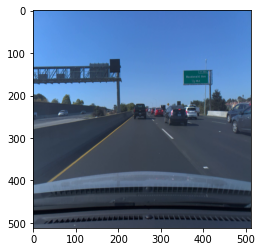

In [16]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

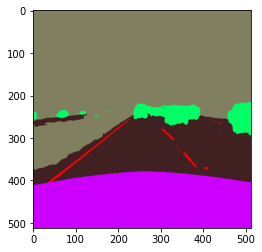

In [17]:
plt.imshow(out[0])

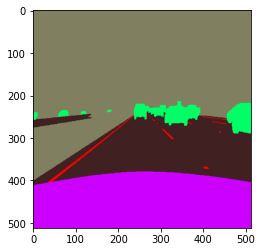

In [18]:
plt.imshow(gt[0])